## Exploratory Data Analysis

### Importing libraries

In [1]:
# libraries to access variables 
import os
from dotenv import load_dotenv
# libraries for data manipulation
import pandas as pd
import numpy as np
# libraries for spark
import findspark
import pyspark 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import *
# libraries for visualisation
import matplotlib.pyplot as plt
%matplotlib inline

### Setting up spark with S3 to read file

In [2]:
os.environ['SPARK_HOME'] = 'C:/Users/kc/spark/spark-3.0.0-preview2-bin-hadoop2.7'
os.environ['HADOOP_HOME'] = '%SPARK_HOME%/hadoop'
os.environ['PYTHON_PATH'] = '%SPARK_HOME%\python\lib\py4j-0.10.8.1-src.zip'

findspark.init()
spark = SparkSession.builder.appName('amzn_reviews').getOrCreate()

In [3]:
load_dotenv()
SECRET_KEY = os.getenv("SECRET_KEY")
ACCESS_KEY = os.getenv("ACCESS_KEY")

In [4]:
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", ACCESS_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", SECRET_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")

reviews = spark.read.load("s3a://amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz", 
                          format="csv", sep="\t", inferSchema="true", header="true")

# to read from file if cannot get s3 working:
#reviews = spark.read.load(os.path.dirname(os.getcwd()) + "\data\raw\amazon_review_data.tsv", format="csv", sep="\t", inferSchema="true", header="true")

### Print basic info about data

In [212]:
print('There are {:,} reviews'.format(reviews.count()))

There are 3,093,869 reviews


In [5]:
reviews.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [214]:
reviews.show(5, truncate=True)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41409413|R2MTG1GCZLR2DK|B00428R89M|     112201306|yoomall 5M Antenn...|     Electronics|          5|            0|          0|   N|                Y|          Five Stars|       As described.| 2015-08-31|
|         US|   49668221|R2HBOEM8LE9928|B000068O48|     734576678|Hosa GPM-103 3.5m...|     Electronics|          5|    

### Data cleaning 

In [215]:
reviews.select([count(when(col(c).isNull(), c)).alias(c) for c in reviews.columns]).show()

+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+
|marketplace|customer_id|review_id|product_id|product_parent|product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|review_body|review_date|
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+
|          0|          0|        0|         0|             0|            0|               8|          8|            8|          8|   8|                8|             12|        197|        119|
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+



In [6]:
# change data type to date and drop null values
reviews = reviews.withColumn('review_date', F.to_date(reviews.review_date)).dropna()

In [217]:
reviews.sort(col('review_date').desc()).show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   23732619|R372S58V6D11AT|B00JOQIO6S|     308169188|Skullcandy Air Ra...|     Electronics|          5|            1|          1|   N|                Y|Overall pleased w...|Works well. Bass ...| 2015-08-31|
|         US|   12338275|R1P4RW1R9FDPEE|B000GGKOG8|     614448099|Channel Master Ti...|     Electronics|          5|    

In [218]:
print('There are {:,} reviews in the cleaned dataframe'.format(reviews.count()))

There are 3,093,660 reviews in the cleaned dataframe


### Timespan of data

In [219]:
first_date = reviews.sort(col('review_date')).first().review_date
last_date = reviews.sort(col('review_date').desc()).first().review_date
diff = (last_date - first_date).days

In [220]:
print('The dataset spans over {:,} days from {} to {}'.format(diff, first_date, last_date))

The dataset spans over 5,927 days from 1999-06-09 to 2015-08-31


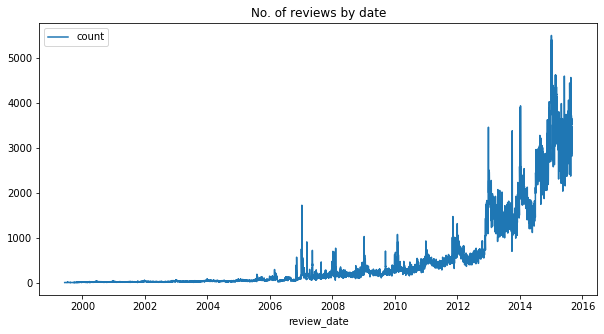

In [221]:
reviews_by_date = reviews.groupBy('review_date').count().toPandas()
reviews_by_date.sort_values(by='review_date').plot(x='review_date', y='count', figsize=(10, 5), title='No. of reviews by date')
plt.show()

### Distribution of reviews by rating 

In [222]:
reviews.groupBy('star_rating').count().show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          1| 358085|
|          3| 238575|
|          5|1781031|
|          4| 536797|
|          2| 179172|
+-----------+-------+



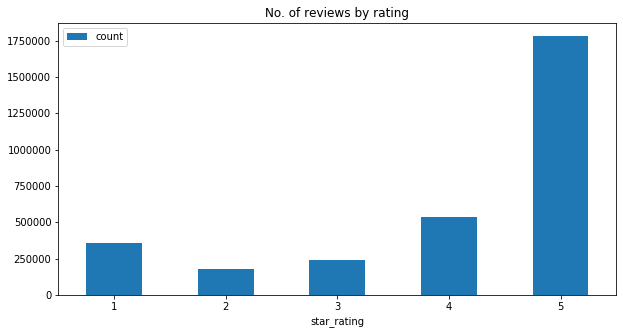

In [25]:
reviews_by_rating = reviews.groupBy('star_rating').count().toPandas()
reviews_by_rating.sort_values(by='star_rating').plot.bar(x='star_rating', y='count', figsize=(10, 5), 
                                                         title='No. of reviews by rating', rot=0)
plt.show()

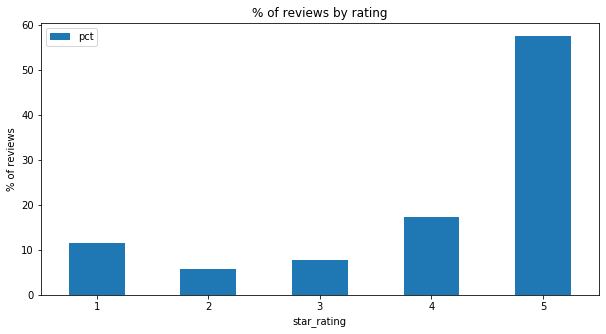

In [26]:
reviews_by_rating['pct'] = (reviews_by_rating['count']/reviews_by_rating.sum()['count'])*100
ax = reviews_by_rating.sort_values(by='star_rating').plot.bar(x='star_rating', y='pct', figsize=(10, 5), 
                                                              title='% of reviews by rating', rot=0)
ax.set_ylabel("% of reviews")
plt.show()

<div class="alert alert-block alert-info">
Most reviews are rated at 5 with negative reviews making a small proportion of the dataset. This makes the dataset imbalanced and will affect our model performance especially on reading negative sentiments. We will also have to be more careful on how we split our training and testing dataset.
</div>

### Distribution of reviews by customers

In [112]:
total_reviews = reviews.count()
reviews.select(F.countDistinct("review_id")).collect()[0][0] == total_reviews

True

In [226]:
unique_customers = reviews.select(F.countDistinct("customer_id")).collect()
print('There are {:,} unique customers'.format(unique_customers[0][0]))

There are 2,154,211 unique customers


In [227]:
print('There are {:,.2f} reviews per customer on average'.format(total_reviews/unique_customers[0][0]))

There are 1.44 reviews per customer on average


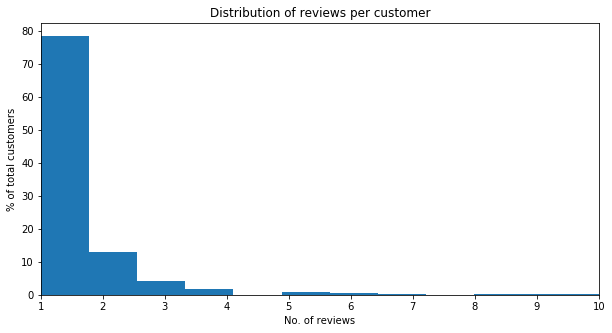

In [228]:
customer_df = reviews.groupBy('customer_id').count().toPandas()

fig, ax = plt.subplots(figsize=(10,5))
customer_df.hist('count', weights=np.ones(len(customer_df['count']))/len(customer_df['count'])*100, bins=300, ax=ax)
ax.set_xlim(1, 10)
ax.grid(False)
ax.set_title('Distribution of reviews per customer')
ax.set_xlabel('No. of reviews')
ax.set_ylabel('% of total customers')
plt.show()

<div class="alert alert-block alert-info">
Most customers only post 1-2 reviews. This is not surprising given that electronics products are lower frequency purchases. This will also make the dataset a better representation of the population as it will not be skewed towards a specific voice.
</div>

### Reviews by marketplace

In [230]:
reviews.groupBy('marketplace').count().show()

+-----------+-------+
|marketplace|  count|
+-----------+-------+
|         US|3093660|
+-----------+-------+



### Distribution of reviews by product

In [113]:
unique_products = reviews.groupBy('product_parent').count().toPandas()
print('There are {:,} unique products in the dataset'.format(len(unique_products)))
print('There are {:,.2f} reviews per product on average in the dataset'.format(total_reviews/len(unique_products)))

There are 166,235 unique products in the dataset
There are 18.61 reviews per product on average in the dataset


In [244]:
unique_products.describe()['count']

count    166235.000000
mean         18.610160
std         158.215953
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max       24828.000000
Name: count, dtype: float64

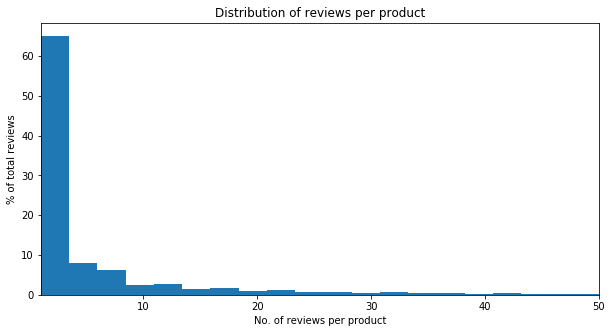

In [254]:
fig, ax = plt.subplots(figsize=(10,5))
unique_products.hist('count', weights=np.ones(len(unique_products['count']))/len(unique_products['count'])*100, 
                     bins=10000, ax=ax)
ax.set_xlim(1, 50)
ax.grid(False)
ax.set_title('Distribution of reviews per product')
ax.set_xlabel('No. of reviews per product')
ax.set_ylabel('% of total reviews')
plt.show()

<div class="alert alert-block alert-info">
It is clear that most products only have few reviews and a few products have alot of reviews. This is a representation of a marketplace where a few products are extremely popular. This could produce selection bias for most of the ratings on products but this is not relevant to our problem.
</div>

### Looking for duplicate reviews

In [73]:
check_duplicates = reviews.groupBy('customer_id', 'product_id').count()
check_duplicates.filter(col('count') != 1) == 0

False

In [42]:
example = check_duplicates.filter(col('count') != 1).select('customer_id', 'product_id').first()
reviews.filter((col('customer_id') == example['customer_id']) & (col('product_id') == example['product_id'])).show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+--------------------+-----------+
|         US|   43843358|R1ICCJYZ72DQGK|B00B46XUQU|     431267324|PORTTA Auto-Switc...|     Electronics|          5|            0|          0|   N|                Y|     Five Stars|Just what I neede...| 2015-03-24|
|         US|   43843358|R19T5CHYOD0HVY|B00B46XUQU|     431267324|PORTTA Auto-Switc...|     Electronics|          5|            0|          

<div class="alert alert-block alert-info">
There are duplicate reviews possibly from repeat purchases of the same product. Given that our goal is to create a sentiment analysis tool, we will keep these reviews.
</div>

### Distribution of reviews for popular products

In [314]:
popular_idx = unique_products.sort_values(by='count').tail(5)['product_parent'].tolist()
print('Most popular products are:')
reviews.filter(reviews.product_parent.isin(popular_idx)).select('product_title').distinct().show(20, False)

Most popular products are:
+-----------------------------------------------------------------------------------------------------------------------+
|product_title                                                                                                          |
+-----------------------------------------------------------------------------------------------------------------------+
|Mediabridge ULTRA Series HDMI Cable (3 Foot) - High-Speed Supports Ethernet, 3D and Audio Return [Newest Standard]     |
|HDMI 2M (6 Feet) Super High Resolution Cable                                                                           |
|Panasonic RP-HJE120E-G Ergo Fit Ear Canal Headphones - Green                                                           |
|PANHHJE120P - PANASONIC RP-HJE120-P HJE120 Earbuds (Pink)                                                              |
|AmazonBasics High-Speed HDMI Cable - 6.5 Feet (2 Meters) Supports Ethernet, 3D, 4K and Audio Return                   

In [114]:
pop_products = unique_products[unique_products['count'] > 6].product_parent.tolist()
pop_reviews = reviews.filter(reviews.product_parent.isin(pop_products))
non_pop_reviews = reviews.filter(~reviews.product_parent.isin(pop_products))

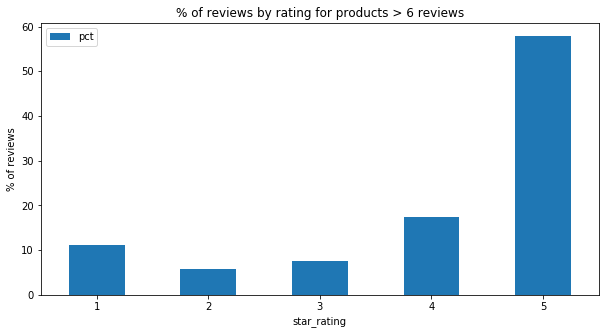

In [23]:
reviews_by_rating_pop = pop_reviews.groupBy('star_rating').count().toPandas()
reviews_by_rating_pop['pct'] = (reviews_by_rating_pop['count']/reviews_by_rating_pop.sum()['count'])*100
ax = reviews_by_rating_pop.sort_values(by='star_rating').plot.bar(x='star_rating', y='pct', figsize=(10, 5), 
                                                              title='% of reviews by rating for products > 6 reviews', rot=0)
ax.set_ylabel("% of reviews")
plt.show()

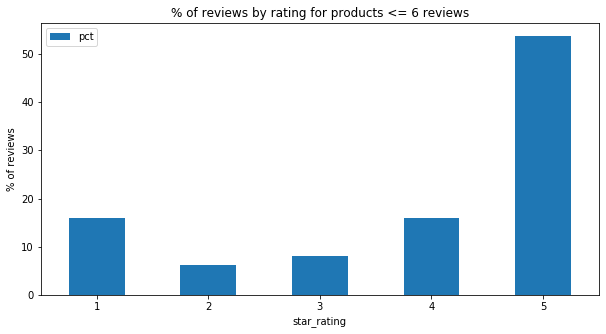

In [24]:
reviews_by_rating_npop = non_pop_reviews.groupBy('star_rating').count().toPandas()
reviews_by_rating_npop['pct'] = (reviews_by_rating_npop['count']/reviews_by_rating_npop.sum()['count'])*100
ax = reviews_by_rating_npop.sort_values(by='star_rating').plot.bar(x='star_rating', y='pct', figsize=(10, 5), 
                                                              title='% of reviews by rating for products <= 6 reviews', rot=0)
ax.set_ylabel("% of reviews")
plt.show()

<div class="alert alert-block alert-info">
Popular products tend to have more 5 star ratings and fewer 1 star ratings which makes sense as the products are popular because they are good. This is a somewhat circular relationship. We can dirrectly look at the correlation between average rating and number of reviews below. Although overall correlation is insignificant, it is clear that the really popular products with lots of reviews have a star rating of 4-5.
</div>

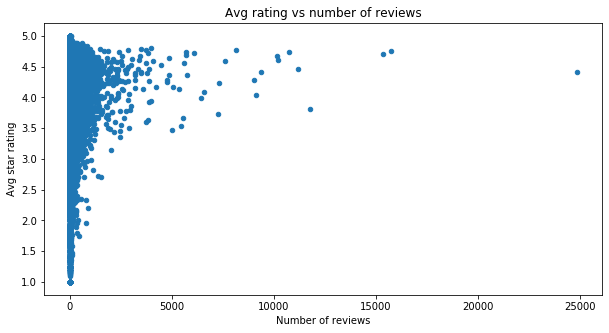

In [140]:
agg_df = reviews.groupBy('product_parent').agg({'review_id':'count', 'star_rating':'mean'}).toPandas()

ax = agg_df.plot.scatter(x='count(review_id)', y='avg(star_rating)', title='Avg rating vs number of reviews', 
                         figsize=(10, 5))
ax.set_xlabel('Number of reviews')
ax.set_ylabel('Avg star rating')
plt.show()

In [170]:
corr = np.corrcoef(agg_df['count(review_id)'], agg_df['avg(star_rating)'])[0][1]
print('The correlation between number of reviews on a product and average star rating is {:.2f}'.format(corr))

The correlation between number of reviews on a product and average star rating is 0.02


In [160]:
star_rating_count = agg_df.groupby('count(review_id)').mean()
star_rating_count['bins'] = pd.qcut(star_rating_count.index, 10, precision=0)
star_rating_bins = star_rating_count.groupby('bins').mean()

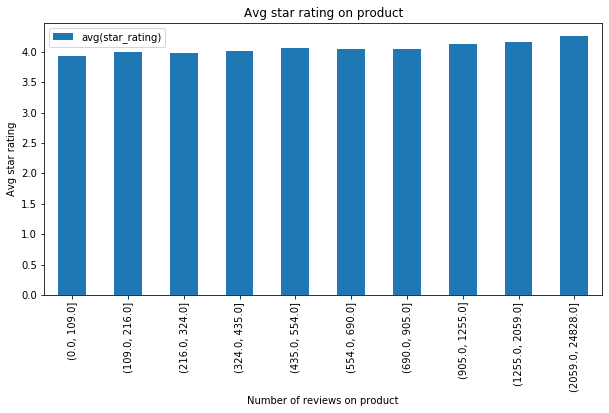

In [162]:
ax = star_rating_bins.plot(kind='bar', y='avg(star_rating)', title='Avg star rating on product', 
                         figsize=(10, 5))
ax.set_xlabel('Number of reviews on product')
ax.set_ylabel('Avg star rating')
plt.show()

<div class="alert alert-block alert-info">
We can see that the average star rating does increase slightly for products in the top 2 deciles. It is also possible that products with fewer reviews don't have better ratings as the reviews are affected by selection bias due to the smaller sample size.
</div>

### Distribution of ratings for vine reviews and verified purchases

In [142]:
vine_pct = reviews.select('vine').filter("vine = 'Y'").count()/reviews.select('vine').filter("vine = 'Y' OR vine = 'N'").count()
print('The % of vine reviews were {:.2f}%'.format(vine_pct*100))

The % of vine reviews were 0.60%


In [143]:
verify_pct = reviews.select('verified_purchase').filter("verified_purchase = 'Y'").count()/reviews.select('verified_purchase').filter("verified_purchase = 'Y' OR verified_purchase = 'N'").count()
print('The % of verified purchases were {:.2f}%'.format(verify_pct*100))

The % of verified purchases were 84.04%


In [144]:
vine_reviews = reviews.filter("vine = 'Y'").select('star_rating').groupby('star_rating').count().toPandas()
non_vine_reviews = reviews.filter("vine = 'N'").select('star_rating').groupby('star_rating').count().toPandas()
verifieds = reviews.filter("verified_purchase = 'Y'").select('star_rating').groupby('star_rating').count().toPandas()
non_verifieds = reviews.filter("verified_purchase = 'N'").select('star_rating').groupby('star_rating').count().toPandas()

In [108]:
def pct_reviews(df): 
    df['pct'] = (df['count']/df.sum()['count'])*100


def reviews_by_rating(df1, df2, title_1, title_2):
    
    pct_reviews(df1)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    df1.sort_values(by='star_rating').plot.bar(x='star_rating', y='pct', title=title_1, figsize=(20, 7), rot=0, ax=ax1)
    ax1.set_ylabel("% of reviews")
    
    pct_reviews(df2)
    df2.sort_values(by='star_rating').plot.bar(x='star_rating', y='pct', title=title_2, rot=0, ax=ax2)
    
    plt.show()

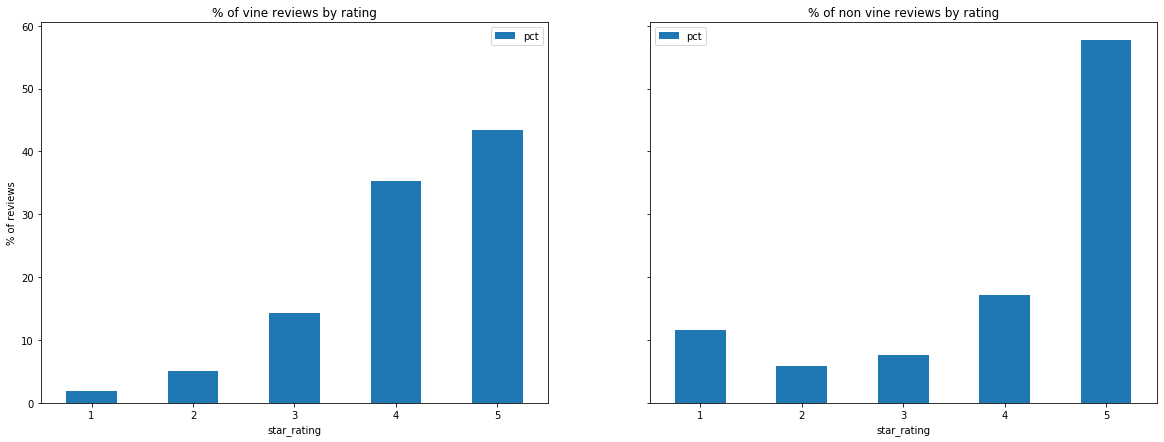

In [109]:
reviews_by_rating(vine_reviews, non_vine_reviews, '% of vine reviews by rating', '% of non vine reviews by rating')

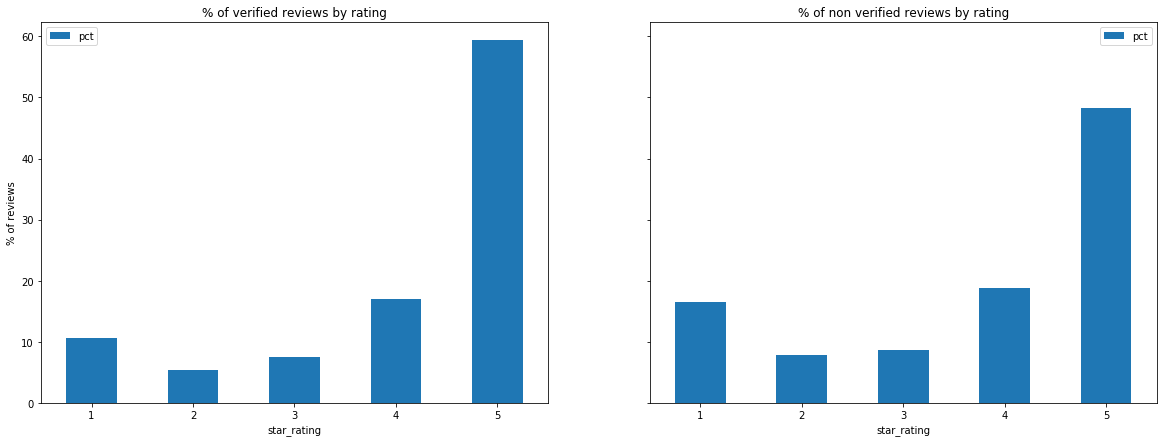

In [110]:
reviews_by_rating(verifieds, non_verifieds, '% of verified reviews by rating', '% of non verified reviews by rating')

<div class="alert alert-block alert-info">
Looking at the results, it shows that vine reviews and verified reviews are a lot less negative. Again, in both cases we are comparing non equal datasets which could affect the results. For example, we could say that vine reviews are less negative as they are reviews on products given for free to high ranking reviewers. But, the sample size is alot smaller than non vine reviews which again introdces significant selection bias.
</div>

### Distribution of ratings by customers

In [148]:
ratings_by_customers = reviews.select('customer_id', 'star_rating').groupBy('customer_id').agg({'customer_id':'count', 
                                                                                        'star_rating':'mean'}).toPandas()

In [210]:
def pct_histogram(df, agg, xlabel, ylabel, title, xlim=None):
    fig, ax = plt.subplots(figsize=(10,5))
    df.hist(agg, weights=np.ones(len(df[agg]))/len(df[agg])*100, bins=100, ax=ax)
    ax.grid(False)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    plt.show()

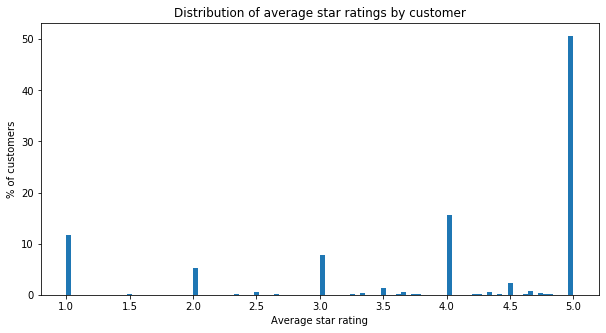

In [211]:
pct_histogram(ratings_by_customers, 'avg(star_rating)', 'Average star rating', '% of customers', 'Distribution of average star ratings by customer')

In [165]:
def bins_plot(df, aggfunc, y_loc, x_label, y_label, title):
    
    df['bins'] = pd.qcut(df.index, 10, precision=0)
    df_bins = df.groupby('bins').agg(aggfunc)
        
    ax = df_bins.plot(kind='bar', y=y_loc, title=title, figsize=(10, 5))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

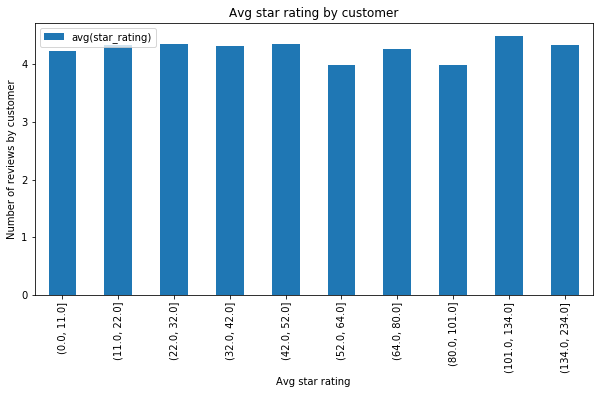

In [166]:
customer_rating_count = ratings_by_customers.groupby('count(customer_id)').mean()
bins_plot(customer_rating_count, 'mean', 'avg(star_rating)', 'Avg star rating', 'Number of reviews by customer', 
          'Avg star rating by customer')

In [171]:
corr = np.corrcoef(customer_rating_count.index, customer_rating_count['avg(star_rating)'])[0][1]
print('The correlation between number of reviews by a customer and average star rating given by customer is {:.2f}'.format(corr))

The correlation between number of reviews by a customer and average star rating given by customer is 0.01


<div class="alert alert-block alert-info">
Based on the first plot, it looks like most customers give 5 stars. This is expected as customers are more likely to buy products with really good reviews. There does not seem to be a distinct relationship between number of reviews posted by a customer and average star ratings given.
</div>

### Distribution of ratings by length of review

In [190]:
reviews_len = reviews.withColumn('review_body_len', F.size(F.split(F.col('review_body'), ' ')))

In [206]:
reviews_length = reviews_len.select('review_body_len').toPandas()
reviews_length.review_body_len.describe()

count    3.093660e+06
mean     7.066564e+01
std      1.186117e+02
min      1.000000e+00
25%      2.000000e+01
50%      3.600000e+01
75%      7.900000e+01
max      8.543000e+03
Name: review_body_len, dtype: float64

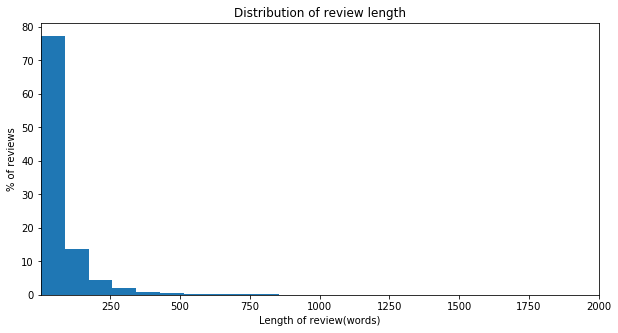

In [219]:
pct_histogram(reviews_length, 'review_body_len', 'Length of review(words)', '% of reviews', 'Distribution of review length', xlim=(1, 2000))

In [196]:
star_rating_len = reviews_len.select('review_body_len', 'star_rating').groupBy('review_body_len').agg({'review_body_len':'count', 
                                                                                                'star_rating':'mean'}).toPandas()

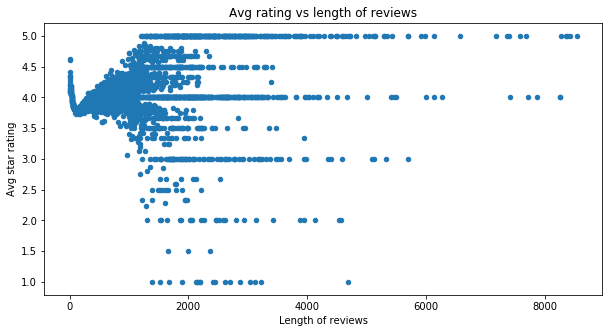

In [223]:
ax = star_rating_len.plot.scatter(x='review_body_len', y='avg(star_rating)', title='Avg rating vs length of reviews', 
                         figsize=(10, 5))
ax.set_xlabel('Length of reviews')
ax.set_ylabel('Avg star rating')
plt.show()

In [224]:
corr = np.corrcoef(star_rating_len['review_body_len'], star_rating_len['avg(star_rating)'])[0][1]
print('The correlation between length of reviews and average star rating is {:.2f}'.format(corr))

The correlation between length of reviews and average star rating is 0.17


<div class="alert alert-block alert-info">
Most reviews are less than 80 words long. From the second plot, we can see that the few extremely long reviews are for 4-5 star rating. This could be because there are lot more 4-5 star rated reviews, hence there is a larger variance in review length. No obvious correlation between length of review and rating given. 
</div>

### Most frquently used words in reviews

In [267]:
from pyspark.sql.functions import regexp_replace, trim, lower, explode
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover

In [394]:
def removePunctuation(column):
    return trim(lower(regexp_replace(column, '[^\sa-zA-Z0-9]', ''))).alias('clean_body')

In [406]:
review_body_clean = reviews_len.withColumn('review_body', regexp_replace(col("review_body"), "<br />", "")).withColumn('review_body', 
                    regexp_replace(col("review_body"), "&#34;", "")).select(removePunctuation(col('review_body')))

tokenizer = Tokenizer(inputCol="clean_body", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

tokenized = tokenizer.transform(review_body_clean)
words_arr = remover.transform(tokenized).select(explode(col('filtered_words')).alias('words')).filter(col('words') != '')

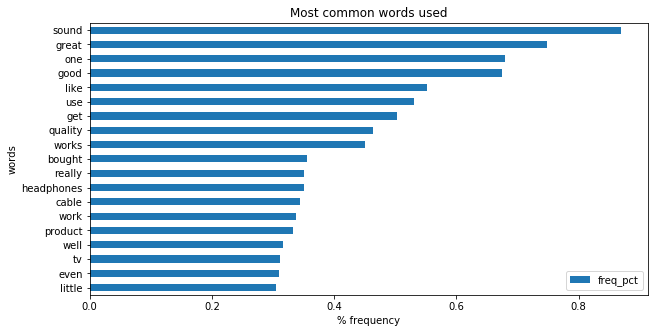

In [407]:
words_df = words_arr.groupBy('words').count().orderBy(col('count').desc()).toPandas()
words_df['freq_pct'] = words_df['count']/words_df['count'].sum()*100

ax = words_df.iloc[0:19].plot(x='words', y='freq_pct', kind='barh', title='Most common words used', figsize=(10, 5))
ax.set_xlabel('% frequency')
ax.invert_yaxis()
plt.show()

<div class="alert alert-block alert-info">
The most popular words are mostly either descriptive of the product (e.g. good, great, like) or segment specific (e.g. sound-mostly for headphones/earphones, cable, headphones, tv).
</div>

## Statistical Analysis

<b>We can do some statistical analysis to see if product ratings are independent of products. We will randomly choose 2 products and perform a chi-squared test on the ratings distribution. Here we use chi-squared as the ratings distribution is discrete and does not allow itself for other tests such as t-test or KS test. We will also limit the runs of the trial to 20 to limit execution time.

In [68]:
from scipy.stats import stats
from collections import Counter
from pyspark.sql import Row

In [167]:
def count_values(sample):
    cnt = Counter([Row(star_rating=1), Row(star_rating=2), Row(star_rating=3), Row(star_rating=4), Row(star_rating=5)])
    for i in sample:
        cnt[i] +=1
    return list(cnt.values())

In [171]:
p_values = []
for i in range(20):
    idx = np.random.choice(len(pop_products), 2, replace=False)
    sample_1 = reviews.filter(col('product_parent') == pop_products[idx[0]]).select('star_rating').collect()
    sample_2 = reviews.filter(col('product_parent') == pop_products[idx[1]]).select('star_rating').collect()
    
    ratings_1 = count_values(sample_1)
    ratings_2 = count_values(sample_2)
    results = chisquare(ratings_1, ratings_2)
    
    p_values.append(results[1])

In [182]:
print('We reject the null hypothesis that there is no difference in the 2 distributions with 95% confidence interval {} times out of 20 random tests '.format(sum(i < 0.05 for i in p_values)))

We reject the null hypothesis that there is no difference in the 2 distributions with 95% confidence interval 17 times out of 20 random tests 


<b>Based on the random sampling of products reviews, it is clear that the ratings provided to products are mostly independent of each other and it is unlikely that 2 differernt products have similar distribution in ratings. Obviously, we have only run the test here 20 times and there are 40,000+ products in the list.